# SEA for Jumping Analysis
## Optimizing stiffness for maximum jump height

How can the stiffness of the SEA be tuned to optimize jump height?

The basic idea is to use a soft spring to let the rotor "run ahead" of the output mass in order to build up potential energy in the spring. In this way the motor can spend a longer amount of time putting energy into the system than if the motor was rigidly coupled to the leg extension of the robot

In [48]:
import numpy as np
import scipy.integrate
import scipy.signal
scipy.integrate.solve_ivp
import matplotlib.pyplot as plt
import itertools
import matplotlib.cm as cm

# Nonlinear

In [49]:
def simulate_nonlinear(mR = 0.1, mB0 = 1.0, F = 10, k = 2, mB_min = 0.1):
    def dynamics(t, x):
        x = np.reshape(x, (-1, 1))
        power = 2.0
#         mB = abs(np.cos(x[2].item())**power * mB0) + mB_min # cosine fade
#         mB = mB0 * abs(1.5 - x[2].item()) + mB_min # linear fade
        mB = mB0
        
        A = np.array([[0, 1, 0, 0],
                  [-k/mR, 0, k/mR, 0],
                  [0, 0, 0, 1],
                  [k/mB, 0, -k/mB, 0]])
        B = np.reshape(np.array([0, 1/mR, 0, 0]), (4,1))
        return (A @ x + B * F).flatten()
    def terminate(t, x):
        return (x[2] - (1.5)).item()
    terminate.terminal=True
    return scipy.integrate.solve_ivp(dynamics, (0,2), np.zeros(4), events=terminate, rtol=1e-6)

def plot_result(results, baseline, i_best=None):
    viridis = cm.get_cmap('viridis', len(results))
    fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(8, 8))
    ax1, ax2 = axs
    for i, result in enumerate(results):
        c = viridis(i/len(results))
        linewidth = 5 if i==i_best else 1
        ax1.plot(result.t, result.y[0,:], '--', label=f'x1_{i}', color=c, linewidth=linewidth)
        ax1.plot(result.t, result.y[2,:], label=f'x2_{i}', color=c,linewidth=linewidth)
        ax2.plot(result.t, result.y[1,:], '--', label=f'v1_{i}', color=c,linewidth=linewidth)
        ax2.plot(result.t, result.y[3,:], label=f'v2_{i}', color=c,linewidth=linewidth)
        
    ax1.plot(baseline.t, baseline.y[0,:], label='x1_baseline', linewidth=5, color='k')
    ax1.plot(baseline.t, baseline.y[2,:], label='x2_baseline', linewidth=5, color='k')
    ax2.plot(baseline.t, baseline.y[1,:], label='v1_baseline', linewidth=5, color='k')
    ax2.plot(baseline.t, baseline.y[3,:], label='v2_baseline', linewidth=5, color='k')
#     ax1.legend()
#     ax2.legend()

In [50]:
from IPython.display import display, HTML
display(HTML("<style>div.output_scroll { height: 100em; }</style>"))

optimal k:  51.53724655961634
velocity multiplier:  1.3382702563258284


<IPython.core.display.Javascript object>


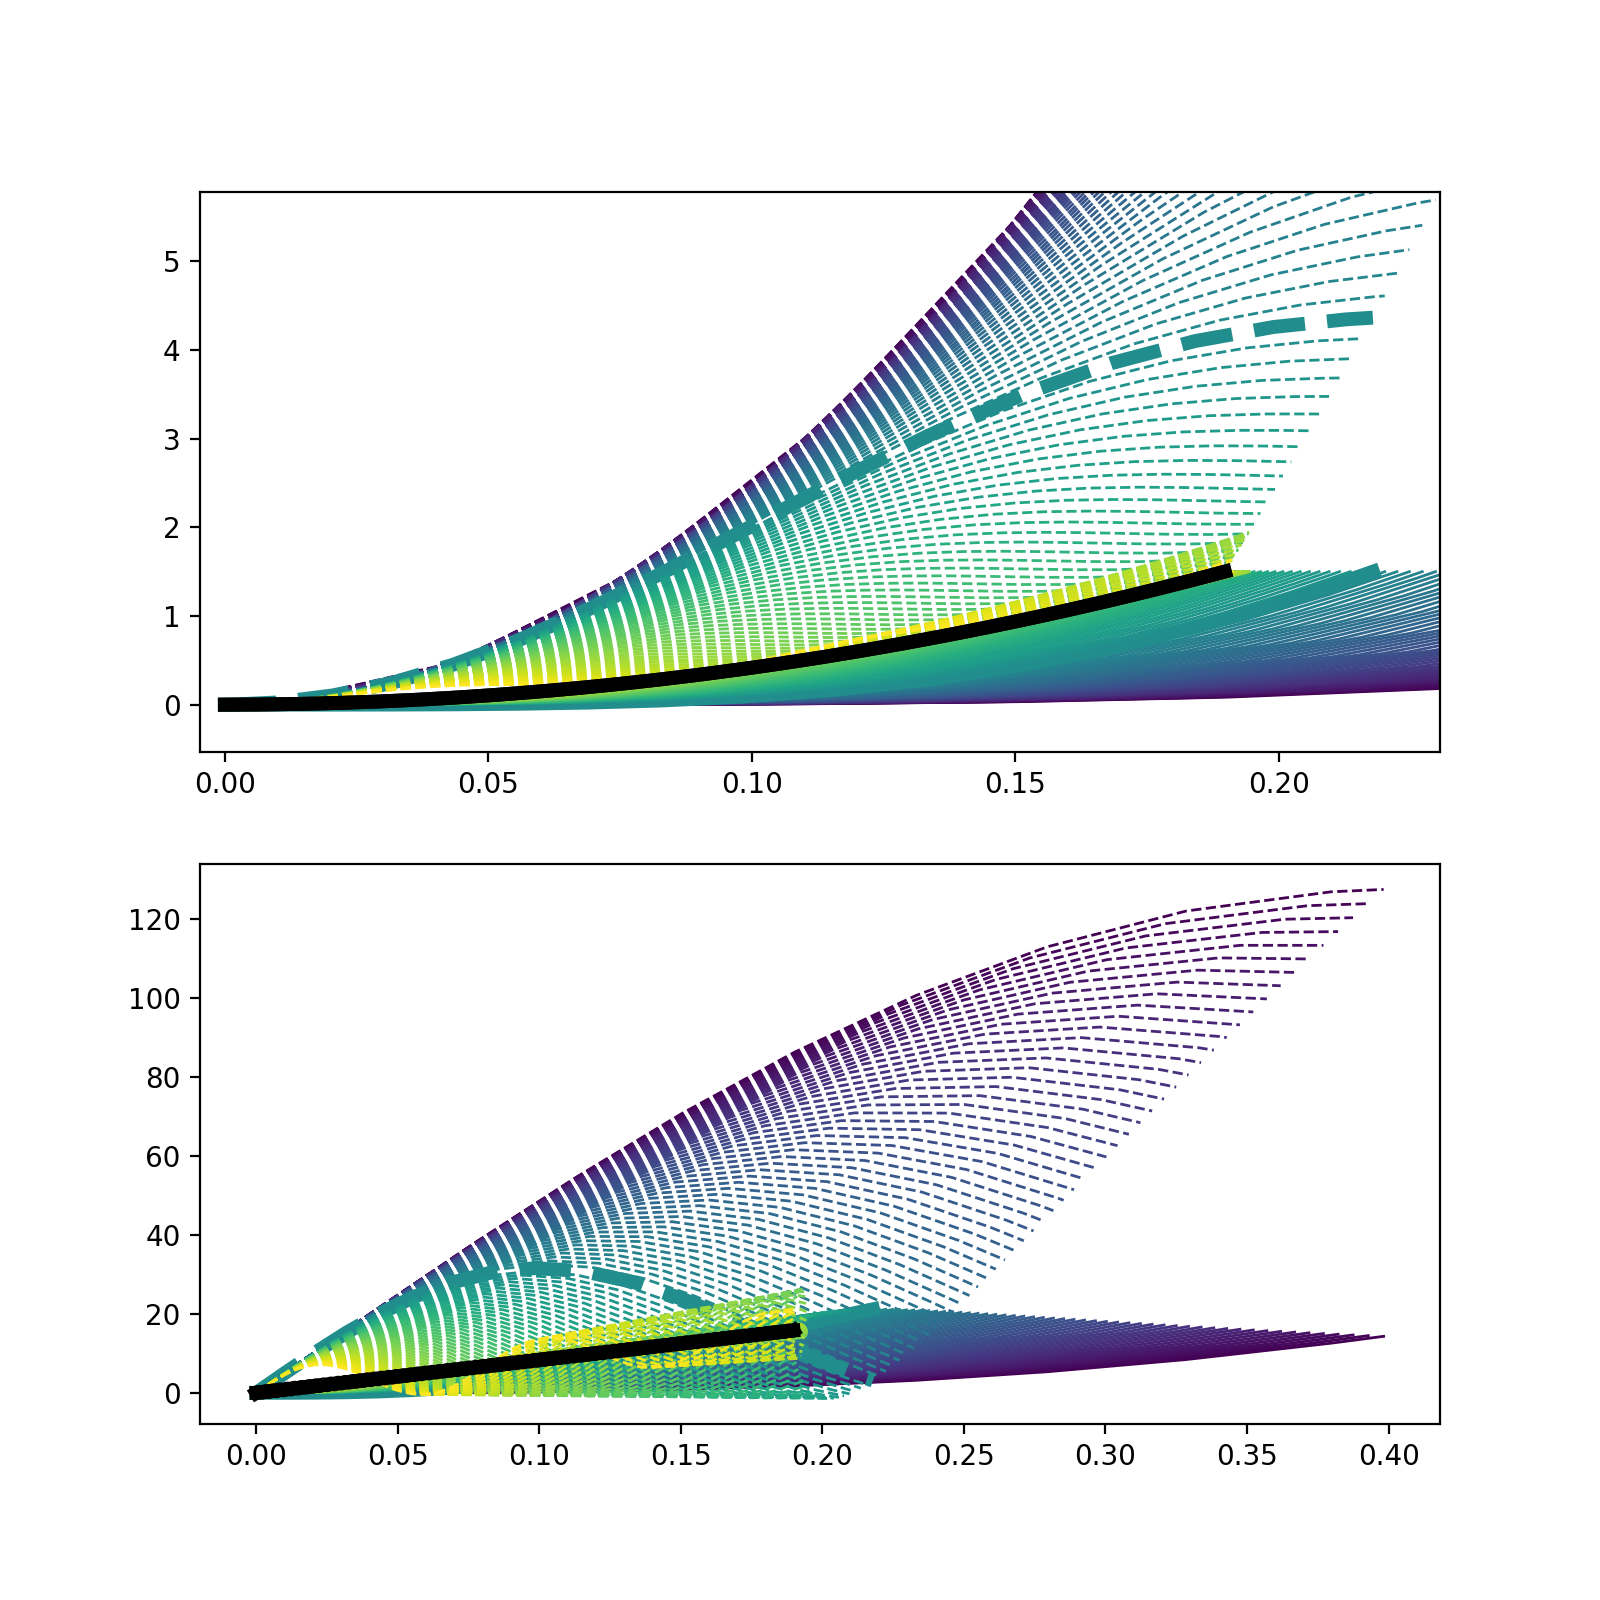

In [76]:
%matplotlib notebook

mR = 0.2
mB0 = 1.0
F = 100
mB_min = 0.1

ks = np.logspace(0.5, 3, 100)
# ks = [2, 3, 4, 5]
# ks = [400]
# print(ks)
results = [simulate_nonlinear(mR, mB0, F, k, mB_min) for k in ks]
baseline = simulate_nonlinear(mR, mB0, F, 1e6, mB_min)


max_v2s = [np.max(result.y[3,:]) for result in results]
i_best = np.argmax(max_v2s)
baseline_v2 = np.max(baseline.y[3,:])
energy_multipliers = np.array(max_v2s) / baseline_v2
print("optimal k: ", ks[i_best])
print("velocity multiplier: ", energy_multipliers[i_best])
plot_result(results, baseline, i_best)

<IPython.core.display.Javascript object>


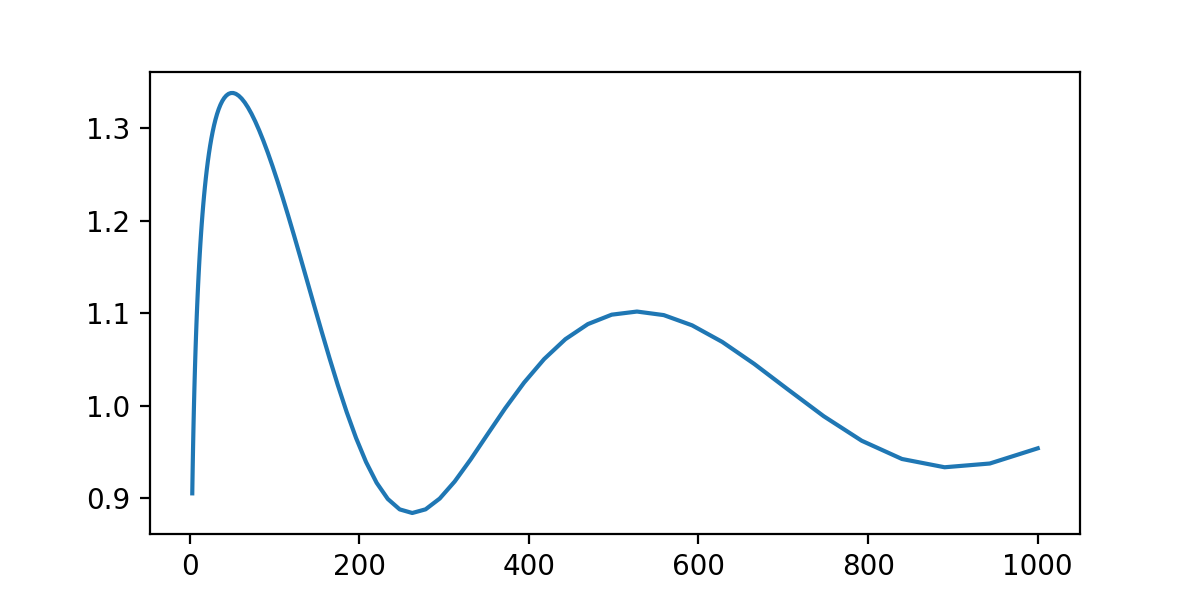

In [75]:
plt.figure(figsize=(6,3))
plt.plot(ks, energy_multipliers)
plt.show()

In [71]:
%matplotlib widget
v2s = np.concatenate([result.y[3,:] for result in results])
ts = np.concatenate([result.t for result in results])
rep_ks = np.concatenate([ks[i]*np.ones(len(res.t)) for i, res in enumerate(results)])
v2s.shape, ts.shape, rep_ks.shape

((2392,), (2392,), (2392,))

In [72]:
import plotly.figure_factory as ff
from scipy.spatial import Delaunay

points2D = np.vstack([rep_ks, ts]).T
tri = Delaunay(points2D)
fig = ff.create_trisurf(x=rep_ks, y=ts, z=v2s,
                         simplices=tri.simplices,
                         title="Torus")
fig.show()

In [73]:
# max inertia
rotor_linear_inertia_0 = 2.5E-5 * 9 * 9 / (0.1**2)
rotor_linear_inertia_0, rotor_linear_inertia_0/0.9

(0.20249999999999999, 0.22499999999999998)

In [74]:
f_max_0 = 1.3 * 9 / 0.1
f_max_0

117.0